# Sales of Alcohol Prediction using LSTM

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. ETL

In [3]:
df = pd.read_csv('../data/Alcohol_Sales.csv', index_col = 0, parse_dates=True)
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
len(df)

325

In [5]:
df = df.rename(columns = {'S4248SM144NCEN': 'Sales'})
df.columns

Index(['Sales'], dtype='object')

## 2. EDA

In [6]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [7]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq=None)

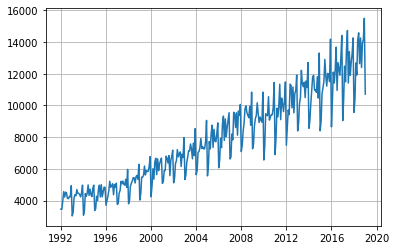

In [8]:
plt.plot(df['Sales'])
plt.grid()
#optionally, you need title, xaxis, yaxis, etc.....

## 3. Feature Extraction

In [9]:
y = df['Sales'].values.astype('float') #.values is basically getting numpy array of pandas
y.shape

(325,)

In [10]:
#test size
test_size = 10

train_set = y[:-test_size]
test_set  = y[-test_size:]

In [11]:
len(train_set), len(test_set)

(315, 10)

## 4. Preprocessing

In anything, for neural network, it's better to normalize, so to reach convergence faster....  Two ways are:
1. Standardizing - normalize around the mean $\displaystyle\frac{x_i - \mu}{\sigma}$
2. MinMax - $\displaystyle\frac{x_i - x_\text{min}}{x_\text{max} - x_\text{min}}$

In signal, we cannot the trust the mean, so minmax is better.

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1)) #by default 0, 1
#for signal, -1 to 1 is a good way to normalize

In [13]:
#to prevent data leakage, you only scale the train set independently of test set
#scaler.fit_transform((m, n))
train_minmax = scaler.fit_transform(train_set.reshape(-1, 1))

In [14]:
train_minmax.min(), train_minmax.max(), train_minmax.mean()

(-1.0, 1.0, -0.20000108542719033)

In [15]:
train_minmax = torch.FloatTensor(train_minmax).reshape(-1)

## 5. Create our batch creator

In [16]:
window_size = 10

def input_data(seq, window_size, label_size=1):
    out = []
    total_length = len(seq)
    for i in range(total_length-window_size):  #if not, we will go out of bound
        window = seq[i:i+window_size]
        label  = seq[i+window_size:i+window_size+label_size]
        out.append((window, label))
    return out

#question: if my window is 10, label size is 1, my seq is ???
#        :  then what is the shape of out??? 

In [17]:
train_data = input_data(train_minmax, window_size)
len(train_data)

305

In [18]:
train_data[0] #sample should be simply (10)

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901]),
 tensor([-0.7933]))

## 6. Define the model

In [19]:
class chakyLSTM(nn.Module):
    #why out_size = 1, because later on, we will label_size = 1
    def __init__(self, input_size = 1, hidden_size=100, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm   = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size) #taking the last hidden state
        
        #optional
        #h0, c0
        #(D*num layer, N, Hin)
        self.hidden = (torch.zeros(1, 1, hidden_size).to(device),
                       torch.zeros(1, 1, hidden_size).to(device))
        
    def forward(self, seq):
        #seq shape: (10)
        seq = seq.reshape(len(seq), 1, -1)
        #seq shape: (10, 1, 1)
        out, (_, _) = self.lstm(seq, self.hidden) #you don't need self.hidden
        #out shape: (L, N, Hout * D) ==> (10, 1, 100)
        out = out[-1, :, :] #(B, Hout)
        #out shape: (1, 100)
        out = self.linear(out)
        #out shape: (1, 1)
        return out
        

## 7. Training!!

In [20]:
torch.manual_seed(999999)
model = chakyLSTM().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model) #why 400?, why 40000????

   400
 40000
   400
   400
   100
     1
______
 41301


In [22]:
epochs = 50

for e in range(epochs):
    
    for seq, ytrain in train_data:
        #seq: (10, ); target: (1, )
        
        seq = seq.to(device)
        ytrain = ytrain.to(device)
        
        # Reset the hidden parameters
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        yhat = model(seq) #1. predict
        yhat = yhat.reshape(-1) #I think you don't need this
        loss = criterion(yhat, ytrain) #2. loss
        optimizer.zero_grad() #3. clear gradients
        loss.backward()  #4. backpropagate
        optimizer.step() #5. update
    
    if e % 10 == 0:
        print(f'Epoch: {e:2.0f} - Loss: {loss:.5f}')

Epoch:  0 - Loss: 0.00139
Epoch: 10 - Loss: 0.00191
Epoch: 20 - Loss: 0.00494
Epoch: 30 - Loss: 0.04755
Epoch: 40 - Loss: 0.00501


## 8. Plot the loss
Skip for brevity

## 9. Inference

In [23]:
future = window_size

#prepare a list of predictions and append on this list
preds = train_minmax[-window_size:].tolist()

#usually we do with torch.no_grad():
model.eval() #same effect as no_grad(): all gradients are turned off; dropout and batchnorm off...
#i just read the documentation and double check
#model.eval() turns off dropout and batchnorm during testing, but not gradients

for _ in range(future):
    #act as the current train
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        yhat = model(seq)
        yhat = yhat.reshape(-1)
        preds.append(yhat.item())
        
preds[-window_size:]
    

[0.5147427320480347,
 0.8013659715652466,
 1.0391591787338257,
 0.3740693926811218,
 0.6498125791549683,
 0.5694629549980164,
 0.6768091917037964,
 0.7508543133735657,
 1.0405813455581665,
 0.13850343227386475]

In [24]:
test_set

array([11919., 14138., 14583., 12640., 14257., 12396., 13914., 14174.,
       15504., 10718.])

## 10. Denormalize our data!

In [25]:
scaler #it already fit, so it knows how to inverse

MinMaxScaler(feature_range=(-1, 1))

In [26]:
preds_real = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

In [27]:
preds_real[-window_size:]

array([[11891.48761111],
       [13568.09025067],
       [14959.061616  ],
       [11068.61891249],
       [12681.57868177],
       [12211.57355526],
       [12839.49536687],
       [13272.62230608],
       [14967.38058084],
       [ 9690.67582709]])

In [28]:
test_set

array([11919., 14138., 14583., 12640., 14257., 12396., 13914., 14174.,
       15504., 10718.])